# Example of PELSA differential expression with `alphatools`

## An example dataset: The original PELSA publication

PELSA [1] is a novel method to investigate protein-ligand interactions through limited proteolysis. Cell lysate is treated with a short pulse of trypsin at extremely high (1:2) enzyme - substrate ratio, which allows for the digestion of surface exposed peptides. If a ligand (such as a small molecule binder) is bound to the protein surface, it stablizes the surrounding protein region and digestion is momentarily slowed. When compared against a control without the ligand, the PELSA-stabilized peptides appear downregulated. We replicate the original publication's analysis of Staurosporine, a pan-kinase binder, and visualize the regulation of kinase targets.

[1]: Li, Kejia, et al. "A peptide-centric local stability assay enables proteome-scale identification of the protein targets and binding regions of diverse ligands." Nature Methods 22.2 (2025): 278-282.

In [ ]:
%load_ext autoreload
%autoreload 2

import tempfile
import pandas as pd
import numpy as np
import logging
from alphatools import io, pp, pl, tl  # input/output, preprocessing, plotting and tools modules
from alphabase.tools.data_downloader import DataShareDownloader
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preparing the dataset using `alphatools` loaders and AnnData factory. 

After downloading the relevant files from the study's PRIDE-repository (https://www.ebi.ac.uk/pride/archive/projects/PXD034606):

- LKJ_20211007_480_Hela_stau_0uM_1.raw
- LKJ_20211007_480_Hela_stau_0uM_2.raw
- LKJ_20211007_480_Hela_stau_0uM_3.raw
- LKJ_20211007_480_Hela_stau_0uM_4.raw
- LKJ_20211007_480_Hela_stau_20uM_1.raw
- LKJ_20211007_480_Hela_stau_20uM_2.raw
- LKJ_20211007_480_Hela_stau_20uM_3.raw
- LKJ_20211007_480_Hela_stau_20uM_4.raw

And processing them with DIANN 2.1.0, the report.parquet file was saved in our datashare alongside sample metadata. We have to extract protein-level intensities and precursor-level intensities from this dataset using the `alphatools.io.AnnDataFactory` class. The resulting AnnData object contains protein-group or precursor quantities and any number of feature-metadata columns (for example, protein groups may have genes as secondary annotation, precursors may have protein groups and genes as secondary annotation).

In [ ]:
report_url = "https://datashare.biochem.mpg.de/s/6piDQGm2yAEdtKQ/download"
sample_metadata_url = "https://datashare.biochem.mpg.de/s/NGof744gWw66Mc8/download"

# Get the report by downloading it to a temporary directory and directly loading it from there
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=report_url, output_dir=temp_dir).download()

    # Get the full report
    full_report = pd.read_parquet(file_path)

    # AnnDataFactory instance containing protein level data
    adata_protein = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="PG.MaxLFQ",
        feature_id_column="Protein.Group",
        sample_id_column="Run",
        secondary_feature_columns=["genes"],
    )

    # AnnDataFactory instance containing gene level data
    adata_gene = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="Genes.MaxLFQ",
        feature_id_column="Genes",
        sample_id_column="Run",
        secondary_feature_columns=["proteins"],
    )

    # AnnDataFactory instance containing precursor level data
    adata_precursor = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="Precursor.Normalised",
        feature_id_column=["Precursor.Id", "Genes", "Protein.Group"],
        sample_id_column="Run",
        secondary_feature_columns=["genes", "sequence"],
    )

/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp625jo9r9/report.parquet does not yet exist


100% |########################################################################|


/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp625jo9r9/report.parquet successfully downloaded (70.8467435836792 MB)


### We focus on Protein Groups and Precursors, and use `pp.add_metadata()` to merge the metadata into our AnnData instances

In [ ]:
# Transfer the run names to the sample metadata to account for lack of rawfile names in the metadata
sample_metadata = pd.read_csv(sample_metadata_url)
sample_metadata["sample"] = sample_metadata["plate"] + "_" + sample_metadata["running_count"].astype(str)

run_name_map = {"_".join(k.split("_")[-2:]): k for k in adata_protein.obs_names}
sample_metadata.index = sample_metadata["sample"].map(run_name_map)

In [ ]:
# Add the metadata to all AnnData instances
adata_protein = pp.add_metadata(adata_protein, sample_metadata, axis=0)
adata_precursor = pp.add_metadata(adata_precursor, sample_metadata, axis=0)

### We log2-transform our data, but keep the untransformed values in a separate layer

In [ ]:
adata_protein.layers["raw"] = adata_protein.X.copy()
adata_precursor.layers["raw"] = adata_precursor.X.copy()

adata_protein = pp.nanlog(adata_protein)
adata_precursor = pp.nanlog(adata_precursor)

In [ ]:
# Inspect the log2-transformed values:
display(adata_protein.to_df().iloc[:5, :5])

# Raw values:
display(adata_protein.to_df(layer="raw").iloc[:5, :5])

proteins,A0A096LP55;P07919,A0A0B4J2F0,A0A1B0GUY1,A0A3B3IS91,A0A3B3IU46;Q9BTL3
raw_name,,,,,
LKJ_20211007_480_Hela_stau_0uM_1,21.790016,23.018673,24.692411,17.029541,23.745449
LKJ_20211007_480_Hela_stau_0uM_2,21.902254,23.051476,24.746101,17.110256,23.861660
LKJ_20211007_480_Hela_stau_0uM_3,21.277990,23.003662,24.555399,17.807335,23.645226
LKJ_20211007_480_Hela_stau_0uM_4,21.540596,23.048594,24.787121,16.149979,23.457727
LKJ_20211007_480_Hela_stau_20uM_1,21.918283,23.059902,24.633326,NaN,23.821888


proteins,A0A096LP55;P07919,A0A0B4J2F0,A0A1B0GUY1,A0A3B3IS91,A0A3B3IU46;Q9BTL3
raw_name,,,,,
LKJ_20211007_480_Hela_stau_0uM_1,3626171.50,8497893.0,27111686.0,133783.515625,14063468.0
LKJ_20211007_480_Hela_stau_0uM_2,3919543.50,8693320.0,28139656.0,141481.781250,15243168.0
LKJ_20211007_480_Hela_stau_0uM_3,2542808.25,8409926.0,24655366.0,229372.937500,13119653.0
LKJ_20211007_480_Hela_stau_0uM_4,3050461.00,8675965.0,28951204.0,72715.656250,11520718.0
LKJ_20211007_480_Hela_stau_20uM_1,3963336.50,8744247.0,26023742.0,NaN,14828694.0


### Perform basic EDA on protein and precursor data

Starting with a panel for feature counts and CVs in each sample

In [ ]:
# Small custom function to generate CVs
# In the future, this could become an alphatools core functionality
import anndata as ad


def make_group_cvs(
    adata: ad.AnnData,
    group_column: str,
) -> None:
    """Calculate CVs for each group in group_columns and store them in adata.var"""
    levels = adata.obs[group_column].unique()
    for level in levels:
        group_adata = pp.filter_by_metadata(adata, {group_column: level}, axis=0)
        stds = group_adata.to_df(layer="raw").std(axis=0)
        means = group_adata.to_df(layer="raw").mean(axis=0)
        adata.var[f"{level}_CV"] = stds / means


# Calculate CVs for the different groups in the condition column
make_group_cvs(adata_protein, "treatment")
make_group_cvs(adata_precursor, "treatment")

We use `alphatools`' plotting syntax to generate a stylized panel with violin plots for sample group feature CVs, and to assess the median intensity of all features across samples.

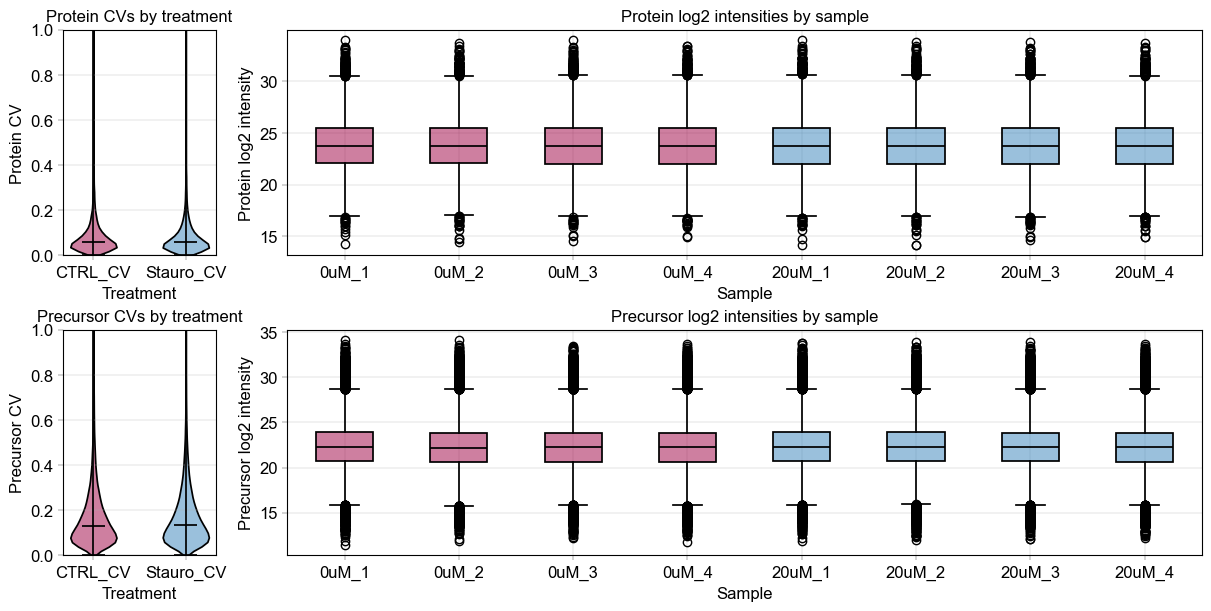

In [ ]:
fig, axm = pl.create_figure(2, 2, figsize=(12, 6), gridspec_kwargs={"width_ratios": [0.5, 3]})

# Define color dictionary for the different treatments
color_dict = {
    "CTRL": pl.BaseColors.get("red"),
    "Stauro": pl.BaseColors.get("blue"),
}

# Map the sample names to their respective colors based on treatment
sample_color_dict = {
    sample: color_dict[treatment]
    for sample, treatment in zip(adata_protein.obs_names, adata_protein.obs["treatment"], strict=False)
}

# Iterative plotting
plot_data = {
    "protein": adata_protein,
    "precursor": adata_precursor,
}
for readout, adata in plot_data.items():
    # start with the CV plots
    ax = axm.next()
    pl.Plots.violinplot(
        ax=ax,
        data=adata.T,
        direct_columns=["CTRL_CV", "Stauro_CV"],
        color_dict={f"{k}_CV": v for k, v in color_dict.items()},
    )
    ax.set_ylim(0, 1)

    pl.label_axes(
        ax=ax,
        xlabel="Treatment",
        ylabel=f"{readout.capitalize()} CV",
        title=f"{readout.capitalize()} CVs by treatment",
    )

    # Then do the log2 abundance plots
    ax = axm.next()
    pl.Plots.boxplot(
        ax=ax,
        data=adata.T,
        direct_columns=adata.obs_names.tolist(),
        color_dict=sample_color_dict,
    )

    # process x ticks to fit the plot better
    xtick_labels = [item.get_text() for item in ax.get_xticklabels()]  # Get xtick labels directly from axes
    xtick_labels = [
        "_".join(x.split("_")[-2:]) for x in xtick_labels
    ]  # Shorten the xtick labels to make them more readable
    _ = ax.set_xticklabels(xtick_labels)  # Set the new xtick labels

    pl.label_axes(
        ax=ax,
        xlabel="Sample",
        ylabel=f"{readout.capitalize()} log2 intensity",
        title=f"{readout.capitalize()} log2 intensities by sample",
    )

    # save figure
    pl.save_figure(
        fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
        filename="pelsa_quantities_overview.svg",
        output_dir="./example_outputs",
    )

### PELSA analysis depends on differential expression

Peptides from the stablized protein regions are expected to appear downregulated. We perform comparative differential expression analysis: On the one hand, we evaluate "vanilla" independent two-sample t-test. On the other, we employ `alphatools`' wrapper of `AlphaQuant` [1], a differential expression method specially adapted for mass-spectrometry proteomics data.

[1]: Ammar, Constantin, et al. "Tree-based quantification infers proteoform regulation in bottom-up proteomics data." bioRxiv (2025): 2025-03.

In [ ]:
comparison = ("Stauro", "CTRL")

In [ ]:
# Vanilla ttest on peptide data
ttest_peptide_results = tl.diff_exp_ttest(
    adata=adata_precursor,
    between_column="treatment",
    comparison=comparison,
    min_valid_values=3,
    equal_var=False,
)

# Join with peptide annotation information
ttest_peptide_results = ttest_peptide_results.join(adata_precursor.var, how="left")

In [ ]:
ttest_peptide_results

,condition_pair,protein,log2fc,p_value,-log10(p_value),fdr,-log10(fdr),method,genes,sequence,CTRL_CV,Stauro_CV
(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVR3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVR3,-0.779221,0.035807,1.446031,0.926634,0.033092,ttest,EIF3J,AAAAAAAGDSDSWDADAFSVEDPVR,0.348759,0.168788
(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVRK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVRK3,-0.163618,0.528045,0.277329,0.982946,0.007470,ttest,EIF3J,AAAAAAAGDSDSWDADAFSVEDPVRK,0.255562,0.243771
(UniMod:1)AAAAAAAPSGGGGGGEEERLEEK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAPSGGGGGGEEERLEEK3,0.131008,0.220292,0.657002,0.981499,0.008110,ttest,MECP2,AAAAAAAPSGGGGGGEEERLEEK,0.116230,0.060557
(UniMod:1)AAAAAAGAASGLPGPVAQGLK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAGAASGLPGPVAQGLK3,-0.001898,0.984930,0.006595,0.999750,0.000109,ttest,IPO9,AAAAAAGAASGLPGPVAQGLK,0.064267,0.109800
(UniMod:1)AAAAAAGEAR2,Stauro_VS_CTRL,(UniMod:1)AAAAAAGEAR2,0.120327,0.652235,0.185596,0.988029,0.005230,ttest,QDPR,AAAAAAGEAR,0.314222,0.103197
...,...,...,...,...,...,...,...,...,...,...,...,...
YYWDEYK2,Stauro_VS_CTRL,YYWDEYK2,NaN,NaN,NaN,NaN,NaN,ttest,RNF123,YYWDEYK,0.335583,NaN
YYYIPQYK2,Stauro_VS_CTRL,YYYIPQYK2,0.139555,0.687191,0.162923,0.988647,0.004959,ttest,NDUFAF2,YYYIPQYK,0.390472,0.094595
YYYQLNSK2,Stauro_VS_CTRL,YYYQLNSK2,0.039896,0.713982,0.146313,0.989125,0.004749,ttest,CBX4,YYYQLNSK,0.115134,0.081185
YYYSDNFFDGQR2,Stauro_VS_CTRL,YYYSDNFFDGQR2,-0.014498,0.935844,0.028796,0.998280,0.000748,ttest,SAV1,YYYSDNFFDGQR,0.152211,0.177059


In [ ]:
# AlphaQuant ttest on full search engine output (takes approx. 3-4 minutes on a M2 MacBook Pro)
comparison_key, alphaquant_results = tl.diff_exp_alphaquant(
    adata=adata_precursor,
    report=full_report,
    between_column="treatment",
    comparison=comparison,
    valid_values_filter_mode="either",
    min_valid_values=3,
    plots="hide",
)
alphaquant_peptide_results = alphaquant_results["peptide"]

INFO:alphaquant.run_pipeline:Starting AlphaQuant


using input type diann_precursor


INFO:alphaquant.diffquant.condpair_analysis:start processeing condpair ('Stauro', 'CTRL')
INFO:alphaquant.norm.normalization:normalized within conditions
INFO:alphaquant.plotting.pairwise:without missingvals (if applicable)
INFO:alphaquant.plotting.pairwise:complete dataset
INFO:alphaquant.norm.normalization:median 0.005768624101893494, mode -0.039726185709202666
INFO:alphaquant.norm.normalization:using median for shift
INFO:alphaquant.norm.normalization:shift comparison by -0.005768624101893494
INFO:alphaquant.norm.normalization:normalized between conditions
INFO:alphaquant.diffquant.background_distributions:Created Background Distribution for 31715 ions. SD: 0.4363087714744898, fraction of missing values: 0.11
INFO:alphaquant.diffquant.background_distributions:Created Background Distribution for 29633 ions. SD: 0.35078616106575505, fraction of missing values: 0.07
INFO:alphaquant.diffquant.background_distributions:Created Background Distribution for 28521 ions. SD: 0.3016853220300592

Alphaquant results are saved into a dictionary based on the quantification level:

- results
  - protein level results
  - proteoform level results
  - peptide level results

### We can use `alphatools` functionality to construct a volcanoplot function 

`alphatools` does not have a dedicated volcanoplotting function. However, it is straightforward to assemble one from the tools already implemented. In its basic form, a volcanoplot consists of:

- figure canvas (`pl.create_figure()`)
- scatterplot (`pl.Plots.scatter()`)
- lines (`pl.add_lines()`)
- labels (`pl.label_plot()`)
- axis labels (`pl.label_axes()`)

In the publication, peptides are aggregated into proteins in a nonstandard way: For each protein, the peptide with the highest significance is assigned its protein ID. This is how a dataset of peptides is converted into a dataset of proteins. We perform the same aggregation in our preprocessing.

In [ ]:
def top_peptides_to_proteins(
    ttest_df: pd.DataFrame,
    y_score_column: str = "-log10(p_value)",
    id_column: str = "protein",
) -> pd.DataFrame:
    """Convert peptide level t-test results to protein level by taking the top peptide per protein."""
    ttest_df = ttest_df.copy()
    return ttest_df.sort_values(y_score_column, ascending=False).groupby(id_column).first().reset_index()


aq_protein_table = top_peptides_to_proteins(alphaquant_peptide_results, id_column="protein")
tt_protein_table = top_peptides_to_proteins(ttest_peptide_results, id_column="genes")

Additionally, we have to annotate all kinases in the data in order to visualize them and perform kinase enrichment scoring. To do this, we load a table from Gerard et al. [1] (http://www.kinhub.org/kinases.html) and transfer the annotations to our data. 

[1]: Manning, Gerard, et al. "The protein kinase complement of the human genome." Science 298.5600 (2002): 1912-1934.

In [ ]:
def annotate_kinases(
    ttest_df: pd.DataFrame,
    kinase_table_path: str,
    gene_id_column: str = "gene",
) -> list:
    """Assign str value for kinase/no kinase based on publication data:

    Manning, Gerard, et al. "The protein kinase complement of the human genome." Science 298.5600 (2002): 1912-1934.,
    table from: http://www.kinhub.org/kinases.html

    """
    ttest_df = ttest_df.copy()
    kinase_table = pd.read_excel(kinase_table_path)
    kinase_list = kinase_table["HGNC Name"].tolist()
    kinase_dict = dict(zip(kinase_list, ["kinase"] * len(kinase_list), strict=False))

    ttest_df["kinase_status"] = ttest_df[gene_id_column].map(kinase_dict).fillna("other")
    return ttest_df


kinase_url = "https://datashare.biochem.mpg.de/s/DnNe8EFSQyqy5pb/download"

aq_protein_table = annotate_kinases(aq_protein_table, kinase_url, "protein")
tt_protein_table = annotate_kinases(tt_protein_table, kinase_url, "genes")

### The main readout is a custom Kinase Enrichment Score:

In the main publication [1] and its follow-up [2], a kinase score is implemented to assess the sensitivity and specificity of the assay. This score derives from the fact that, in the ideal case we should only see kinase peptides downregulated. In practice, there are off-targets, i.e. peptides/proteins that appear as downregulated even though they are not kinases. The score is the ratio of downregulated (log2fc < 0) kinases/non-kinases at 80 % specificity when ranking by -log10(p_value). 

Imagine a boundary moving down from the highest point in the left half of the volcanoplot. Each time it passes a point, we count if the point is a kinase or a non-kinase. When the ratio of passed kinases / passed non-kinases becomes smaller than 0.8 we state that 80 % specificity is reached. However many kinases we have up to this point is our score.

[1]: Li, Kejia, et al. "A peptide-centric local stability assay to unveil protein targets of diverse ligands." bioRxiv (2023): 2023-10.

[2]: Li, Kejia, et al. "High-throughput peptide-centric local stability assay extends protein-ligand identification to membrane proteins, tissues, and bacteria." bioRxiv (2025): 2025-04.

In [ ]:
def kinase_score(
    ttest_df: pd.DataFrame,
    id_col: str,
    score_column: str = "-log10(p_value)",
    max_candidates: int = 500,
    threshold: float = 0.8,
) -> dict | None:
    """Perform kinase scoring analysis per HT-Pelsa.

    1. Sort peptides by -log10(significance) (score_column) descending
    2. Consider only regulated peptides, i.e. log2fc < 0
    3. Iterate through ranks, calculating the cumulative kinase fraction
         (number of kinases / total number of peptides)
    4. Stop when kinase fraction drops below min_kinase_pct or max_candidates is reached

    """
    ttest_df = ttest_df.copy()
    print(
        f"Total unique kinases in the dataset: {ttest_df.loc[ttest_df['kinase_status'] == 'kinase', id_col].nunique()}"
    )

    # Restrict to downregulated peptides
    ttest_df = ttest_df[ttest_df["log2fc"] < 0]
    print(
        f"Total unique kinases in the downregulated dataset: {ttest_df.loc[ttest_df['kinase_status'] == 'kinase', id_col].nunique()}"
    )

    # Rank peptides by score
    ttest_df = ttest_df.sort_values(score_column, ascending=False).reset_index(drop=True)
    ttest_df["rank"] = ttest_df.index + 1

    # Iterate through ranks and record the kinase fraction
    def _kinase_fraction(df: pd.DataFrame) -> float:
        kinase_count = df[df["kinase_status"] == "kinase"].shape[0]
        total_count = df.shape[0]
        return kinase_count / total_count if total_count > 0 else np.nan

    kinase_fractions = []
    for n in range(1, len(ttest_df) + 1):
        subset = ttest_df.head(n)
        kinase_fraction = _kinase_fraction(subset)
        score_threshold = subset[score_column].iloc[-1]
        kinase_fractions.append(
            {
                "rank": n,
                "kinase_fraction": kinase_fraction,
                "score_threshold": score_threshold,
                "n_kinases": subset[subset["kinase_status"] == "kinase"].shape[0],
                "n_total": subset.shape[0],
            }
        )

        if n >= max_candidates and kinase_fraction < threshold:
            break

    kinase_fraction_df = pd.DataFrame(kinase_fractions)

    # Determine score based on specificity threshold
    above_threshold = kinase_fraction_df[kinase_fraction_df["kinase_fraction"] >= threshold]
    optimal_row = above_threshold.iloc[-1] if not above_threshold.empty else None
    if optimal_row is None:
        print("No suitable threshold found.")
        return None

    return {
        "threshold": optimal_row["score_threshold"],
        "n_candidates": optimal_row["rank"],
        "n_kinases": optimal_row["n_kinases"],
        "n_non_kinases": optimal_row["n_total"] - optimal_row["n_kinases"],
        "kinase_percentage": optimal_row["kinase_fraction"],
    }

In [ ]:
# uniform coloring
color_dict = {
    "kinase": pl.BaseColors.get("red"),
    "other": pl.BaseColors.get("grey"),
}

### First, inspect the aggregated protein results for the standard t-test

Total unique kinases in the dataset: 276
Total unique kinases in the downregulated dataset: 215
Kinase scoring threshold at -log10(p_value) = 3.34, covering 108.0 proteins with 87.0 kinases (80.6%)


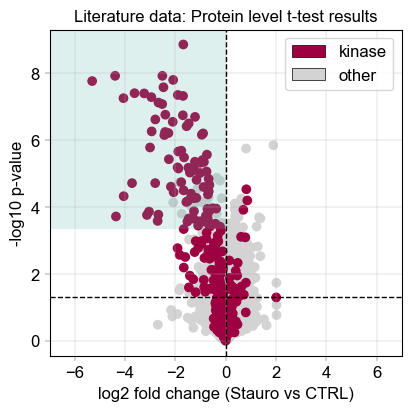

In [ ]:
fig, axm = pl.create_figure(1, 1, figsize=(4, 4))
ax = axm.next()

pl.Plots.scatter(
    ax=ax,
    data=tt_protein_table,
    x_column="log2fc",
    y_column="-log10(p_value)",
    xlim=(-7, 7),
    color_map_column="kinase_status",
    color_dict=color_dict,
    legend="auto",
)

pl.add_lines(
    ax=ax,
    intercepts=[0],
    linetype="vline",
    linestyle="--",
)

pl.add_lines(
    ax=ax,
    intercepts=[-np.log10(0.05)],
    linetype="hline",
    linestyle="--",
)

pl.label_axes(
    ax=ax,
    xlabel="log2 fold change (Stauro vs CTRL)",
    ylabel="-log10 p-value",
    title="Literature data: Protein level t-test results",
)

# We draw a rectangle to indicate the kinase scoring threshold

ttest_ks_result = kinase_score(tt_protein_table, id_col="genes", threshold=0.8)
if ttest_ks_result:
    rect = Rectangle(
        xy=(-7, ttest_ks_result["threshold"]),  # Bottom-left corner
        width=7,  # Width to cover from -7 to 0 (downregulated region)
        height=tt_protein_table["-log10(p_value)"].max()
        + 0.5
        - ttest_ks_result["threshold"],  # Height with small padding
        linewidth=2,
        facecolor=pl.BaseColors.get("green", alpha=0.2),
    )
    print(
        f"Kinase scoring threshold at -log10(p_value) = {ttest_ks_result['threshold']:.2f}, covering {ttest_ks_result['n_candidates']} proteins with {ttest_ks_result['n_kinases']} kinases ({ttest_ks_result['kinase_percentage'] * 100:.1f}%)"
    )
    ax.add_patch(rect)

# save figure
pl.save_figure(
    fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
    filename="Literature_PELSA_TTEST_AggProt_Stauro.svg",
    output_dir="./example_outputs",
)

### Next, inspect the protein-aggregated results from Alphaquant

Total unique kinases in the dataset: 276
Total unique kinases in the downregulated dataset: 215
Kinase scoring threshold at -log10(p_value) = 3.40, covering 137.0 proteins with 110.0 kinases (80.3%)


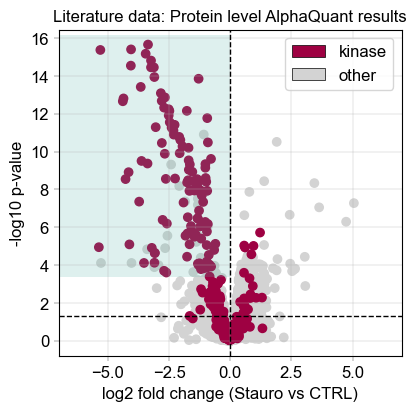

In [ ]:
import numpy as np

fig, axm = pl.create_figure(1, 1, figsize=(4, 4))
ax = axm.next()

pl.Plots.scatter(
    ax=ax,
    data=aq_protein_table,
    x_column="log2fc",
    y_column="-log10(p_value)",
    xlim=(-7, 7),
    color_map_column="kinase_status",
    color_dict=color_dict,
    legend="auto",
)

pl.add_lines(
    ax=ax,
    intercepts=[0],
    linetype="vline",
    linestyle="--",
)

pl.add_lines(
    ax=ax,
    intercepts=[-np.log10(0.05)],
    linetype="hline",
    linestyle="--",
)

pl.label_axes(
    ax=ax,
    xlabel="log2 fold change (Stauro vs CTRL)",
    ylabel="-log10 p-value",
    title="Literature data: Protein level AlphaQuant results",
)

# We draw a rectangle to indicate the kinase scoring threshold
aq_ks_result = kinase_score(aq_protein_table, id_col="protein", threshold=0.8)
if aq_ks_result:
    rect = Rectangle(
        xy=(-7, aq_ks_result["threshold"]),  # Bottom-left corner
        width=7,  # Width to cover from -7 to 0 (downregulated region)
        height=aq_protein_table["-log10(p_value)"].max() + 0.5 - aq_ks_result["threshold"],  # Height with small padding
        linewidth=2,
        facecolor=pl.BaseColors.get("green", alpha=0.2),
    )
    print(
        f"Kinase scoring threshold at -log10(p_value) = {aq_ks_result['threshold']:.2f}, covering {aq_ks_result['n_candidates']} proteins with {aq_ks_result['n_kinases']} kinases ({aq_ks_result['kinase_percentage'] * 100:.1f}%)"
    )
    ax.add_patch(rect)

# save figure
pl.save_figure(
    fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
    filename="Literature_PELSA_AlphaQuant_AggProt_Stauro.svg",
    output_dir="./example_outputs",
)

### Visualize the kinase enrichment results compared to literature data

In Figure 2 b of Kejia, Li et al., the number of downregulated vs. kinase proteins at 80 % specificity (as computed above) is given at 135 downregulated candidates and 108 kinase targets. Note that their result were computed using an Empirical Bayes test. We can visualize this data and compare to our `alphatools` differential expression data:

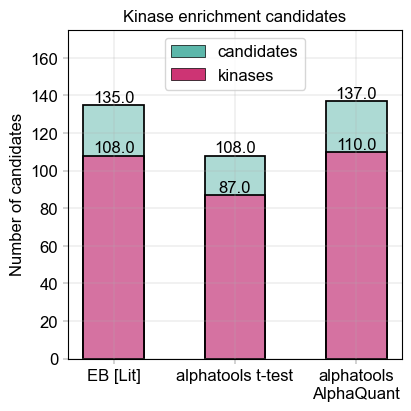

In [ ]:
total_candidates = pd.DataFrame(
    {
        "group": ["EB [Lit]", "alphatools t-test", "alphatools\nAlphaQuant"],
        "value": [135, ttest_ks_result["n_candidates"], aq_ks_result["n_candidates"]],
    }
)

total_kinases = pd.DataFrame(
    {
        "group": ["EB [Lit]", "alphatools t-test", "alphatools\nAlphaQuant"],
        "value": [108, ttest_ks_result["n_kinases"], aq_ks_result["n_kinases"]],
    }
)

color_dict = {
    "candidates": pl.BaseColors.get("green"),
    "kinases": pl.BaseColors.get("red", lighten=0.1, alpha=0.8),
}

fig, axm = pl.create_figure(1, 1, figsize=(4, 4))

# First, plot the total candidates
ax = axm.next()
ax.set_ylim(0, 175)

pl.Plots.barplot(
    ax=ax,
    data=total_candidates,
    grouping_column="group",
    value_column="value",
    color=pl.BaseColors.get("green"),
)

pl.label_plot(
    ax=ax,
    x_values=range(1, len(total_candidates) + 1),
    y_values=total_candidates["value"].tolist(),
    labels=total_candidates["value"].astype(str).tolist(),
    label_kwargs={"va": "bottom", "ha": "center"},
)

# Then, add the kinases
pl.Plots.barplot(
    ax=ax,
    data=total_kinases,
    grouping_column="group",
    value_column="value",
    color=pl.BaseColors.get("red", lighten=0.3),
)

pl.label_plot(
    ax=ax,
    x_values=range(1, len(total_kinases) + 1),
    y_values=total_kinases["value"].tolist(),
    labels=total_kinases["value"].astype(str).tolist(),
    label_kwargs={"va": "bottom", "ha": "center"},
)

pl.label_axes(
    ax=ax,
    xlabel="",
    ylabel="Number of candidates",
    title="Kinase enrichment candidates",
)

pl.add_legend_to_axes(
    ax=ax,
    levels=color_dict,
)

# save figure
pl.save_figure(
    fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
    filename="Literature_PELSA_Kinase_Enrichment_Candidates_Comparison.svg",
    output_dir="./example_outputs",
)

### In summary, we saw that `alphatools`...

- can swiftly load precursor and protein data into `AnnData` instances
- contains standardized, 'plug and play' modules for proteomics differential expression
- Equals/outperforms the empirical Bayes approach from literature, demonstrating that we have a strong framework for analysing PELSA-data in-house using `AlphaQuant`.